# Analysis and visualization of spatial transcriptomics data

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import suppress
import igraph as ig
from scipy.sparse import csr_matrix
import leidenalg as la

from crowflow import StochasticClusteringRunner

from sklearn.neighbors import NearestNeighbors

/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading the data

We will use a Visium spatial transcriptomics dataset of the human lymphnode, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node).

In [2]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

100%|██████████| 7.86M/7.86M [00:00<00:00, 33.4MB/s]
100%|██████████| 29.3M/29.3M [00:05<00:00, 5.52MB/s]
/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACAAGTATCTCCCA-1,1,50,102,6732,8.814776,27944.0,10.237993,33.241483,41.071429,48.375322,57.572287,248.0,5.517453,0.887489
AAACAATCTACTAGCA-1,1,3,43,6759,8.818778,25685.0,10.153702,23.507884,33.965349,42.631886,53.054312,239.0,5.480639,0.930504
AAACACCAATAACTGC-1,1,59,19,8590,9.058470,42942.0,10.667629,22.502445,31.770761,40.584975,50.815053,473.0,6.161207,1.101486
AAACAGAGCGACTCCT-1,1,14,94,7236,8.886962,31916.0,10.370894,21.948239,31.990224,41.101642,52.603710,348.0,5.855072,1.090362
AAACAGCTTTCAGAAG-1,1,43,9,6890,8.837971,30932.0,10.339579,26.357817,38.132032,47.575327,57.590844,793.0,6.677083,2.563688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,5771,8.660774,19649.0,9.885833,27.131152,35.950939,44.429742,55.000254,209.0,5.347107,1.063667
TTGTTTCATTAGTCTA-1,1,60,30,6354,8.756997,21557.0,9.978502,24.238067,32.263302,40.265343,51.152758,208.0,5.342334,0.964884
TTGTTTCCATACAACT-1,1,45,27,6517,8.782323,22175.0,10.006766,21.506201,30.593010,39.098083,50.119504,192.0,5.262690,0.865840
TTGTTTGTATTACACG-1,1,73,41,4476,8.406708,12268.0,9.414831,24.078904,34.268014,43.193675,54.964134,121.0,4.804021,0.986306


## QC and preprocessing

Let's perform some basic filtering of spots based on total counts and expressed genes.

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

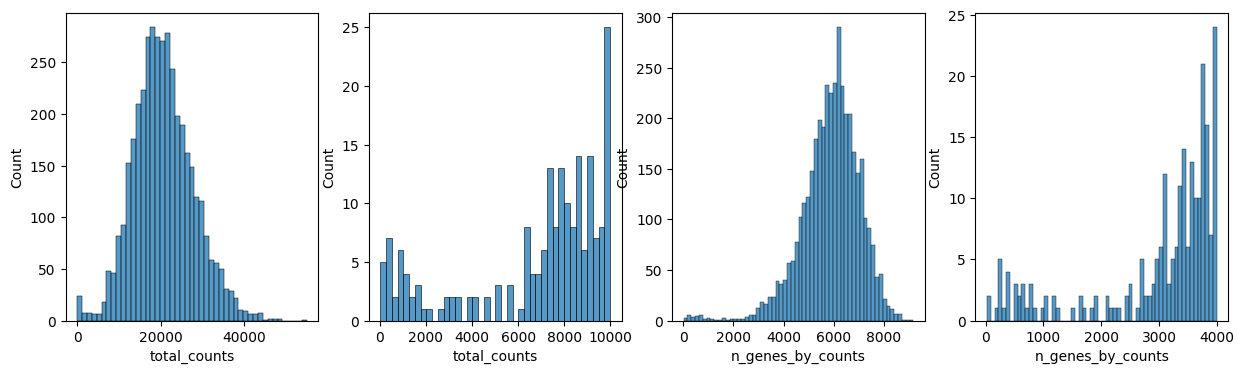

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [5]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 3861


Let's normalize Visium counts data and detect highly-variable genes.

In [6]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

## Clustering

To embed and cluster the manifold encoded by transcriptional similarity, we proceed as in the standard clustering tutorial.

In [7]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [8]:

def get_igraph_from_adjacency(adjacency: csr_matrix, *, directed: bool = False):
    """Convert a SciPy CSR sparse adjacency matrix to an igraph Graph."""
    sources, targets = adjacency.nonzero()
    weights = adjacency[sources, targets].A1  # Convert to 1D array if it's a matrix
    g = ig.Graph(directed=directed)
    g.add_vertices(adjacency.shape[0])
    g.add_edges(zip(sources, targets))
    with suppress(KeyError):
        g.es['weight'] = weights
    return g


adjacency_matrix = adata.obsp["connectivities"]
ig_graph = get_igraph_from_adjacency(adjacency_matrix)


We will use `StochasticClusteringRunner` to run the leiden algorithm 30 times (while changing the random seed). Because la.find_partition does not return labels directly (stores them on `membership` property) we need to specify that `labels_name`="membership"

In [9]:
runner = StochasticClusteringRunner(
    clustering_algo=la.find_partition,
    parameter_name_seed="seed",
    n_runs=30,
    labels_name="membership",
    partition_type = la.RBConfigurationVertexPartition
)

results = runner.run(ig_graph)

Let's check the majority-voting label clusters and ECC.

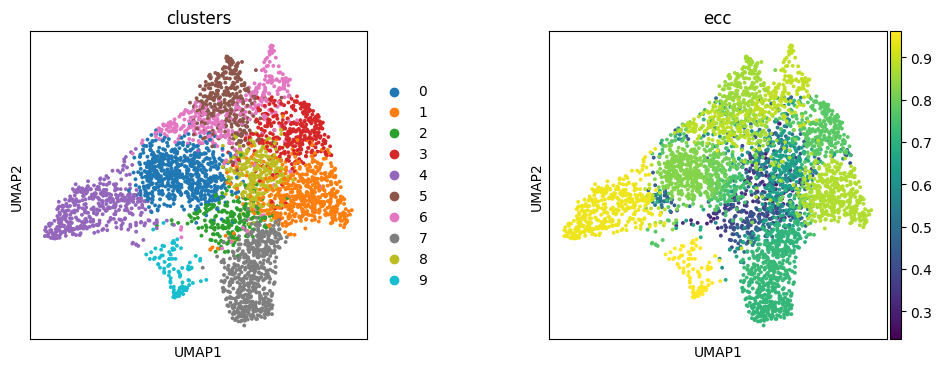

In [10]:
adata.obs["ecc"] = results["ecc"]
adata.obs["clusters"] = pd.Categorical(results["majority_voting_labels"])

plt.rcParams["figure.figsize"] = (4, 4)

# Plot UMAP with a 2x2 grid
sc.pl.umap(
    adata,
    color=[ "clusters", "ecc"],
    wspace=0.4,
    ncols=2
)

Let's visualise the clustering in the spatial coordinates.

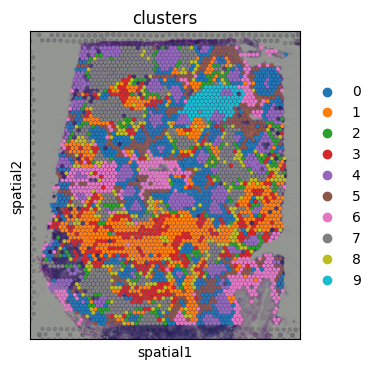

In [11]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

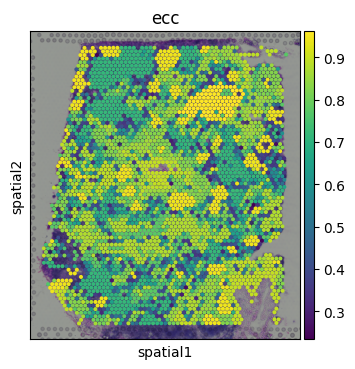

In [12]:
sc.pl.spatial(adata, img_key="hires", color="ecc", size=1.5)

Spots belonging to the same cluster in gene expression space often co-occur in spatial dimensions. For instance, spots belonging to cluster 5 are often surrounded by spots belonging to cluster 0.

In [13]:
from crowflow import ParameterOptimizer

np.random.seed(42)

# Find the optimal parameters based on ECC - similar to fine tuning in supervised learning.
parameters_optimize_dict = {"resolution_parameter": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

parameter_optimizer = ParameterOptimizer(
    clustering_algo=la.find_partition,
    parameter_name_seed="seed",
    parameters_optimize_dict=parameters_optimize_dict,
    n_runs=30,
    verbose=True,
    labels_name="membership",
    partition_type = la.RBConfigurationVertexPartition
)
optimizer_results_ecc_df, stochastic_clustering_results = parameter_optimizer.run(ig_graph)

Running with resolution_parameter=0.2

 Median ECC:  0.7265190803010191
--------------------------------------------------------------
Running with resolution_parameter=0.3

 Median ECC:  0.6700963846955836
--------------------------------------------------------------
Running with resolution_parameter=0.4

 Median ECC:  0.8551378498496561
--------------------------------------------------------------
Running with resolution_parameter=0.5

 Median ECC:  0.8349001103816361
--------------------------------------------------------------
Running with resolution_parameter=0.6

 Median ECC:  0.8054672947303821
--------------------------------------------------------------
Running with resolution_parameter=0.7

 Median ECC:  0.8244328544211355
--------------------------------------------------------------
Running with resolution_parameter=0.8

 Median ECC:  0.8329805082586984
--------------------------------------------------------------
Running with resolution_parameter=0.9

 Median ECC:  0.

In [14]:
optimizer_results_ecc_df

,param,ecc,median_ecc
0,resolution_parameter_0.2,"[0.8048535222583713, 0.7265190803010191, 0.883...",0.726519
1,resolution_parameter_0.3,"[0.7697398557452593, 0.6486028024973236, 0.987...",0.670096
2,resolution_parameter_0.4,"[0.8567763635584705, 0.7760025468400206, 0.988...",0.855138
3,resolution_parameter_0.5,"[0.8440698304953572, 0.8349001103816361, 0.986...",0.834900
4,resolution_parameter_0.6,"[0.7534523380508179, 0.8178092814236754, 0.980...",0.805467
5,resolution_parameter_0.7,"[0.8244328544211355, 0.8754265208893409, 0.985...",0.824433
6,resolution_parameter_0.8,"[0.8647710413870816, 0.8767270309680361, 0.975...",0.832981
7,resolution_parameter_0.9,"[0.8580214389397692, 0.8229985068984421, 0.969...",0.822999
8,resolution_parameter_1.0,"[0.8752335159574757, 0.7141141490960585, 0.960...",0.804826


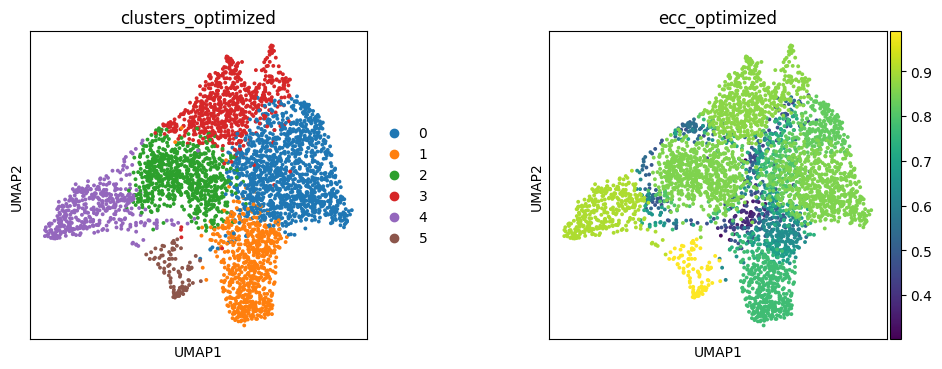

In [15]:
adata.obs["ecc_optimized"] = stochastic_clustering_results['resolution_parameter_0.4']['ecc']
adata.obs["clusters_optimized"] = pd.Categorical(stochastic_clustering_results['resolution_parameter_0.4']['majority_voting_labels'])

sc.pl.umap(
    adata,
    color=["clusters_optimized", "ecc_optimized"],
    wspace=0.4,
    ncols=2  # Specify 2 columns
)

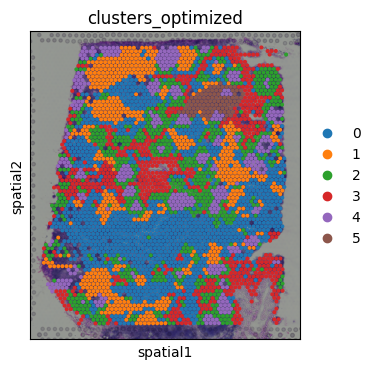

In [16]:
sc.pl.spatial(adata, img_key="hires", color="clusters_optimized", size=1.5)

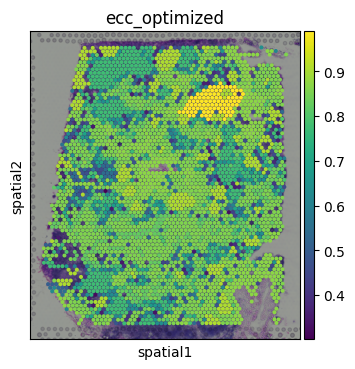

In [17]:
sc.pl.spatial(adata, img_key="hires", color="ecc_optimized", size=1.5)

In [18]:
def compute_local_spatial_consistency(coords, labels, k=10, eps=1e-6):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    # Exclude the point itself (first neighbor)
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    
    lsc_scores = []
    for i in range(coords.shape[0]):
        # Inverse-distance weights
        weights = 1.0 / (distances[i] + eps)
        if hasattr(labels, "iloc"):
            # labels is a pandas Series: use .iloc for position-based indexing
            neighbor_labels = labels.iloc[indices[i]]
            self_label = labels.iloc[i]
        else:
            # Assume labels is a numpy array; index directly
            neighbor_labels = labels[indices[i]]
            self_label = labels[i]
        same_label = (neighbor_labels == self_label).astype(float)
        lsc = np.sum(weights * same_label) / np.sum(weights)
        lsc_scores.append(lsc)
        
    return np.mean(lsc_scores), lsc_scores

In [22]:
def compute_local_spatial_consistency_with_null(coords, labels, k=10, eps=1e-6, n_permutations=100):
    observed_mean, observed_scores = compute_local_spatial_consistency(coords, labels, k=k, eps=eps)
    
    # Build null distribution
    null_means = []
    for _ in range(n_permutations):
        permuted_labels = np.random.permutation(labels)
        mean_perm, _ = compute_local_spatial_consistency(coords, permuted_labels, k=k, eps=eps)
        null_means.append(mean_perm)
    
    null_means = np.array(null_means)
    null_mean = np.mean(null_means)
    null_std = np.std(null_means)
    
    # Compute a z-score and relative improvement metric
    z_score = (observed_mean - null_mean) / (null_std + eps)
    relative_improvement = observed_mean / (null_mean + eps)
    absolute_improvement = observed_mean - null_mean

    print(" Observed mean consistency:", observed_mean)
    print(" Null mean consistency:", null_mean)
    print(" Absolute improvement:", absolute_improvement)
    print(" Z-score:", z_score)
    print(" Relative improvement:", relative_improvement)
    
    return {
        "observed_mean": observed_mean,
        "observed_scores": observed_scores,
        "absolute_improvement": absolute_improvement,
        "null_mean": null_mean,
        "null_std": null_std,
        "z_score": z_score,
        "relative_improvement": relative_improvement
    }

In [37]:
results_dict_default = {}
for k in np.arange(3, 16, 2):
    print(f"running with k={k}")
    result = compute_local_spatial_consistency_with_null(adata.obsm['spatial'], adata.obs["clusters"], k=k, n_permutations=100)
    results_dict_default[k] = {"k": k, "observed_mean": result['observed_mean'], "null_mean": result["null_mean"], "absolute_improvement": result['absolute_improvement'], "relative_improvement": result["relative_improvement"]}
    print("*"*20)

df_default = pd.DataFrame.from_dict(results_dict_default, orient='index')
df_default["type"] = "default"

running with k=3
 Observed mean consistency: 0.5154065593702807
 Null mean consistency: 0.11694586427077691
 Absolute improvement: 0.39846069509950377
 Z-score: 102.84628279962172
 Relative improvement: 4.407185798303377
********************
running with k=5
 Observed mean consistency: 0.5117494103248946
 Null mean consistency: 0.11693895834893114
 Absolute improvement: 0.3948104519759635
 Z-score: 123.40624058557708
 Relative improvement: 4.376172332795877
********************
running with k=7
 Observed mean consistency: 0.4978176228621692
 Null mean consistency: 0.1172910358445438
 Absolute improvement: 0.3805265870176254
 Z-score: 137.74129873967553
 Relative improvement: 4.244257670844467
********************
running with k=9
 Observed mean consistency: 0.48020779593262364
 Null mean consistency: 0.11709353993337256
 Absolute improvement: 0.36311425599925107
 Z-score: 148.92113738461347
 Relative improvement: 4.101026368999482
********************
running with k=11
 Observed mean c

In [38]:
results_dict_optimised = {}
for k in np.arange(3, 16, 2):
    print(f"running with k={k}")
    result = compute_local_spatial_consistency_with_null(adata.obsm['spatial'], adata.obs["clusters_optimized"], k=k, n_permutations=100)
    results_dict_optimised[k] = {"k": k, "observed_mean": result['observed_mean'], "null_mean": result["null_mean"], "absolute_improvement": result['absolute_improvement'], "relative_improvement": result["relative_improvement"]}
    print("*"*20)

df_optimised = pd.DataFrame.from_dict(results_dict_optimised, orient='index')
df_optimised["type"] = "optimised"


running with k=3
 Observed mean consistency: 0.6580607087809395
 Null mean consistency: 0.21646863192522567
 Absolute improvement: 0.4415920768557138
 Z-score: 95.42773981958536
 Relative improvement: 3.0399677909936624
********************
running with k=5
 Observed mean consistency: 0.652441547750587
 Null mean consistency: 0.21663019246260895
 Absolute improvement: 0.4358113552879781
 Z-score: 113.87690783498614
 Relative improvement: 3.0117617889362815
********************
running with k=7
 Observed mean consistency: 0.6397778947160754
 Null mean consistency: 0.2167090060955794
 Absolute improvement: 0.42306888862049596
 Z-score: 125.37425456702965
 Relative improvement: 2.9522305233746473
********************
running with k=9
 Observed mean consistency: 0.6237342687507704
 Null mean consistency: 0.2167068360221562
 Absolute improvement: 0.4070274327286142
 Z-score: 151.50369448353072
 Relative improvement: 2.8782266492984583
********************
running with k=11
 Observed mean co

In [39]:
df_full = pd.concat([df_default, df_optimised])

In [44]:
df_full.head()

,k,observed_mean,null_mean,absolute_improvement,relative_improvement,type
3,3,0.515407,0.116946,0.398461,4.407186,default
5,5,0.511749,0.116939,0.394810,4.376172,default
7,7,0.497818,0.117291,0.380527,4.244258,default
9,9,0.480208,0.117094,0.363114,4.101026,default
11,11,0.466310,0.116917,0.349393,3.988351,default


In [48]:
def plot_spatial_optimisation(df_full, y_axis, y_axis_label):
    plt.figure(figsize=(8, 6))

    for t in df_full['type'].unique():
        subset = df_full[df_full['type'] == t]
        plt.plot(subset['k'], subset[y_axis], marker='o', linestyle='-', label=t)

    # Labels and legend
    plt.xlabel('k')
    plt.ylabel(y_axis_label)
    plt.title(f'{y_axis_label} vs k, Colored by Type')
    plt.legend(title='Type')

    plt.show()

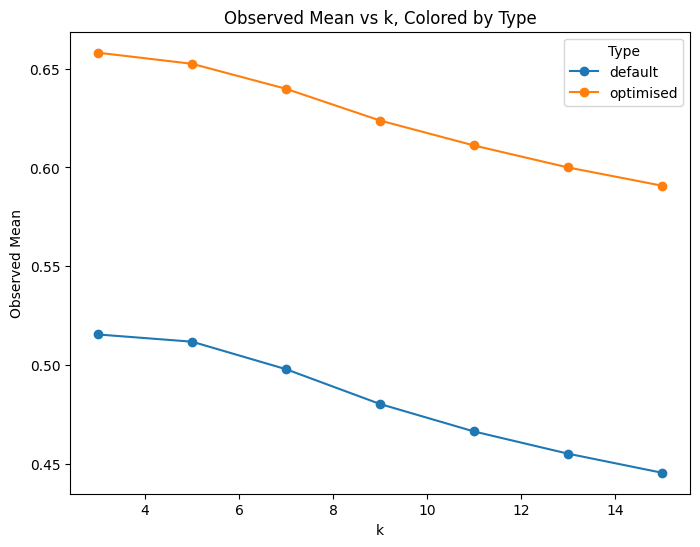

In [49]:
plot_spatial_optimisation(df_full, "observed_mean", "Observed Mean")

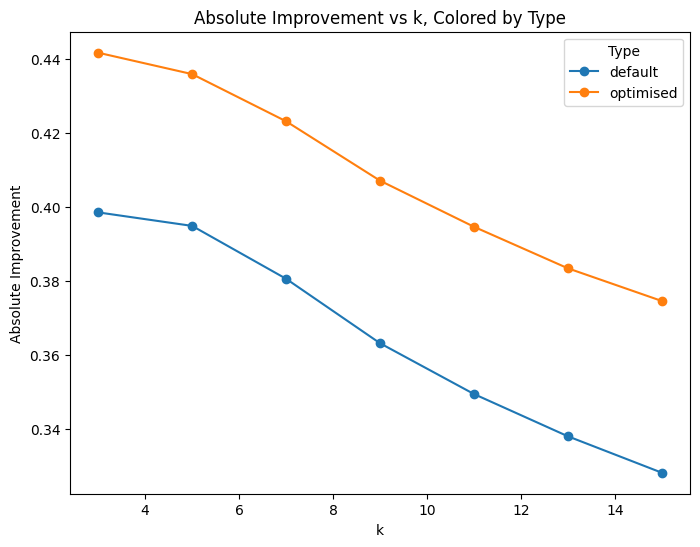

In [50]:
plot_spatial_optimisation(df_full, "absolute_improvement", "Absolute Improvement")